# Testing aggregate prediction performance as a function of beta distribution parameters

Conclusions: can't conclude best beta distribution parameters from Monte Carlo simulations.  Need to test it on the real outcomes.

In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import beta
import statistics

# Local imports
from src import process
from src import plot
from src import util

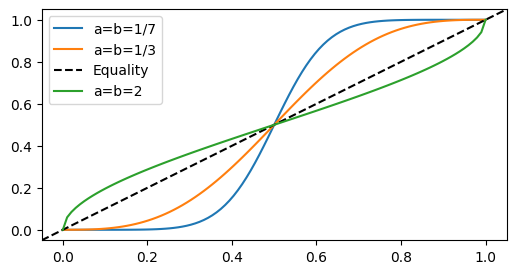

In [3]:
# Plot example beta with low a and b
x = np.linspace(0, 1, 100)

y_lower = beta.ppf(x, a=1 / 7, b=1 / 7)
y_low = beta.ppf(x, a=1 / 3, b=1 / 3)
# y_1 = beta.ppf(x, a=1, b=1) # Equivalent to equality line
y_high = beta.ppf(x, a=2, b=2)

plt.figure(figsize=(6, 3))
plt.plot(x, y_lower)
plt.plot(x, y_low)
plt.axline((0, 0), slope=1, linestyle="dashed", color="black")
plt.plot(x, y_high)
plt.legend(["a=b=1/7", "a=b=1/3", "Equality", "a=b=2"])
plt.show()

In [4]:
# Load mean super forecasters predictions
data_file = os.path.join(process.RESULTS_FOLDER, "sf_mean_predictions.csv")
data = pd.read_csv(data_file)
data = data / 100
SF_preds = data.values
# data.head()

# Load my predictions
data_file = os.path.join(process.RESULTS_FOLDER, "my_final_predictions.csv")
my_preds = pd.read_csv(data_file)
my_preds = my_preds / 100
my_preds = my_preds.values

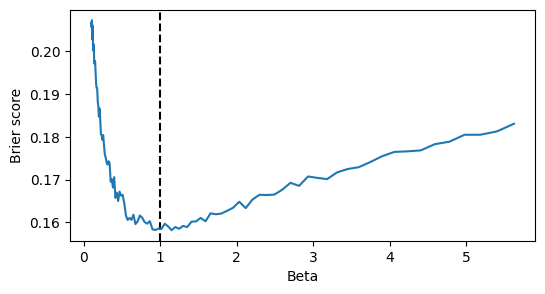

In [5]:
# Run simulations for each beta value
# For now, assume a==b for the function
n_simulations = 1000  # Number of simulations oer beta value
param_vec = np.linspace(0, 10, 30)
param_vec = np.logspace(-1, 0.75, 100)

# Initialize the Brier score vector
brier_scores = []

base_preds = SF_preds
base_preds = my_preds

# Loop over the beta values
for param_val in param_vec:
    # Transform the predictions
    transformed_predictions = beta.ppf(base_preds, param_val, param_val)
    # Run Monte Carlo simulation
    (
        my_brier_scores,
        base_brier_scores,
        my_score_percentiles,
    ) = util.sim_binary_comparison(
        n_simulations, transformed_predictions, base_preds, base_preds_are_probs=True
    )
    # Store the Brier score
    brier_scores.append(statistics.mean(my_brier_scores))

# Plot the Brier score as a function of beta
plt.figure(figsize=(6, 3))
plt.axvline(x=1, color="black", linestyle="dashed")
plt.plot(param_vec, brier_scores)
plt.xlabel("Beta")
plt.ylabel("Brier score")
plt.show()

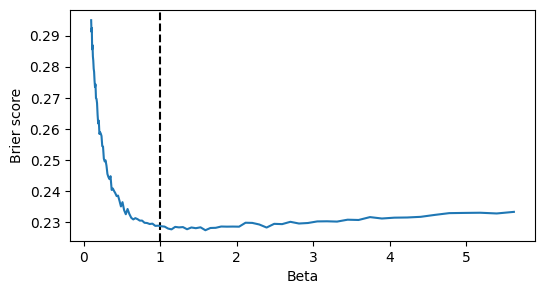

In [6]:
# Add noise to the underlying probabilities and re-run the analysis

# For now, assume a==b for the function
n_simulations = 1000  # Number of simulations oer beta value
param_vec = np.logspace(-1, 2, 100)
param_vec = np.logspace(-1, 0.75, 100)

# Initialize the Brier score vector
brier_scores = []

# Use SF_preds with added noies as the base predictions
# TODO: should switch to adding noise after transforming probabilities with logit
# then tranform back into probabilities
base_preds = SF_preds.copy()
base_preds = base_preds + np.random.normal(0, 0.4, base_preds.shape)
base_preds = np.clip(base_preds, 0.01, 0.99)

# base_preds = np.random.uniform(0.01, 0.99, base_preds.shape)
# base_preds = np.repeat(0.9, SF_preds.shape[0])

initial_preds = np.random.uniform(0.4, 0.5, base_preds.shape)
initial_preds = SF_preds.copy()

# Loop over the beta values
for param_val in param_vec:
    # Transform the predictions
    transformed_predictions = beta.ppf(initial_preds, param_val, param_val)
    # Run Monte Carlo simulation
    (
        my_brier_scores,
        base_brier_scores,
        my_score_percentiles,
    ) = util.sim_binary_comparison(
        n_simulations, transformed_predictions, base_preds, base_preds_are_probs=True
    )
    # Store the Brier score
    brier_scores.append(statistics.mean(my_brier_scores))

# Plot the Brier score as a function of beta
plt.figure(figsize=(6, 3))
plt.axvline(x=1, color="black", linestyle="dashed")
plt.plot(param_vec, brier_scores)
plt.xlabel("Beta")
plt.ylabel("Brier score")
plt.show()